# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.339059,False,1.523297
1,1.009676,True,4.361143
2,0.376290,True,7.623149
3,0.832195,True,6.504141
4,0.585708,True,4.155991
...,...,...,...
995,-0.560865,False,-2.036794
996,-0.439966,False,-1.173392
997,-1.545073,False,-2.369035
998,1.565063,True,5.896693


<AxesSubplot:xlabel='v0'>

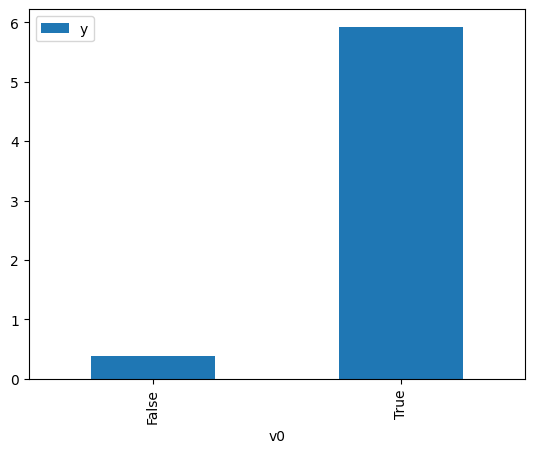

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

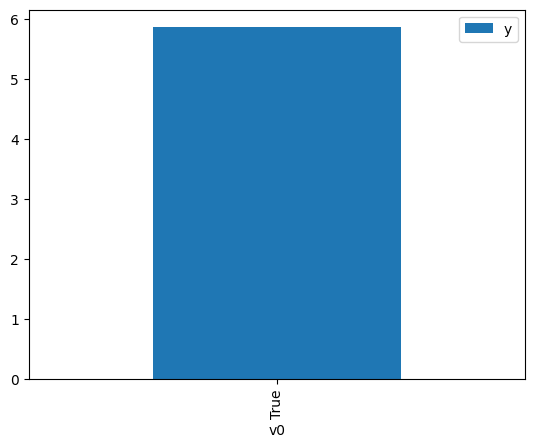

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.370839,False,-1.426270,0.668533,1.495812
1,1.956810,False,1.876996,0.017484,57.195309
2,-0.382916,False,-1.248201,0.673950,1.483791
3,0.924422,False,1.606464,0.126667,7.894687
4,0.789872,False,1.731581,0.160123,6.245181
...,...,...,...,...,...
995,1.518796,False,2.492069,0.041540,24.073284
996,1.617724,False,3.848876,0.034233,29.211278
997,1.956810,False,1.876996,0.017484,57.195309
998,-0.185325,False,-0.376236,0.580432,1.722855


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.592847,True,3.291838,0.239989,4.166851
1,1.404890,True,4.027509,0.948201,1.054629
2,0.727954,True,5.849403,0.822222,1.216216
3,-0.582116,True,4.759021,0.243990,4.098536
4,-0.085492,True,4.919241,0.469623,2.129369
...,...,...,...,...,...
995,0.064974,True,4.467355,0.545902,1.831831
996,0.821375,True,3.852592,0.848300,1.178828
997,1.791186,True,6.668863,0.975690,1.024916
998,-0.507771,True,3.795654,0.272923,3.664033


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          1.407e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        19:25:36   Log-Likelihood:                         -1439.7
No. Observations:                1000   AIC:                                      2883.
Df Residuals:                     998   BIC:                                      2893.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2791      0.039     32.390      0.000       1.202       1.357
x2             5.0288      0.056     89.202      0.000       4.918       5.139
==============================================================================
Omnibus:                        3.317   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                3.386
Skew:                           0.130   Prob(JB):                        0.184
Kurtosis:                       2.884   Cond. No.                         2.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""